In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import pickle
import random
from collections import Counter
import time

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

## pytorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence


import torchtext
from torchtext import data
from torchtext.datasets import YahooAnswers
from torchtext.data import get_tokenizer

from torchtext.vocab import vocab, GloVe

import spacy

# Load data

In [ ]:
# Load data

# set up training and test set iterators 

train_iter, test_iter = YahooAnswers(split = ('train', 'test'))

## convert training and test data to map-style datasets (lists) - easier to work with

train_original = list(train_iter)
test_original = list(test_iter)

## original train dataset is very large: 
print(len(train_original))

# for prototyping purposes, we will only use 5% of this data
train_keep, train_discard = train_test_split(train_original, train_size = 0.05, 
                                        random_state = 123)

# further divide the training set into train and validation set
# 70% train, 30% validation

train_data, val_data = train_test_split(list(train_keep), train_size = 0.7, 
                                        random_state = 123)

1400000


In [ ]:
print(f'Train instances: {len(train_original)}')
print(f'Val instances: {len(val_data)}')
print(f'Test instances: {len(test_original)}')

Train instances: 1400000
Val instances: 21000
Test instances: 60000


# Exploratory analysis

### Set up nlp module

In [ ]:
# download Spacy large English language model into google colab environment

!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [ ]:
#Link alias 'en' to large language english model

!python -m spacy link en_core_web_lg en --force

# use spacy tokenizer
tokenizer = get_tokenizer('spacy', language = 'en')

✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_lg -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


### EDA

In [ ]:
# get distribution of labels and text lengths in the train set

label_counter = Counter()
token_counter = Counter()

for label, text in train_data:
  label_counter[label] += 1 
  token_counter[len(tokenizer(text))] += 1

print(label_counter)
print(token_counter)

# make sure the number of labels = number of instances 
print(f'Number of labels: {sum(label_counter.values())}')
print(f'Number of text lengths: {sum(token_counter.values())}')

Counter({9: 4987, 3: 4980, 7: 4971, 2: 4947, 6: 4941, 5: 4880, 4: 4860, 1: 4858, 8: 4829, 10: 4747})
Counter({24: 514, 23: 510, 26: 507, 27: 497, 29: 490, 30: 488, 22: 484, 25: 482, 34: 479, 36: 477, 35: 474, 31: 473, 28: 469, 33: 466, 21: 465, 20: 458, 37: 451, 39: 447, 18: 444, 32: 437, 19: 436, 16: 435, 38: 435, 17: 426, 40: 421, 43: 413, 42: 409, 46: 405, 44: 403, 49: 401, 47: 400, 41: 391, 45: 390, 15: 389, 48: 387, 52: 379, 51: 376, 50: 373, 59: 364, 54: 359, 57: 358, 55: 357, 53: 352, 58: 348, 60: 342, 14: 341, 56: 339, 61: 339, 13: 334, 64: 310, 62: 308, 72: 304, 74: 302, 70: 300, 63: 297, 66: 297, 69: 293, 12: 292, 68: 292, 65: 290, 71: 287, 77: 286, 73: 286, 79: 265, 67: 265, 78: 264, 81: 262, 76: 260, 82: 260, 11: 250, 80: 248, 83: 245, 88: 244, 75: 242, 86: 240, 84: 236, 93: 234, 85: 230, 90: 217, 92: 212, 91: 208, 96: 205, 87: 203, 100: 201, 94: 198, 89: 198, 97: 198, 95: 196, 99: 196, 106: 189, 102: 187, 10: 186, 114: 186, 98: 183, 104: 182, 101: 182, 116: 181, 105: 180, 

### Visualise distribution

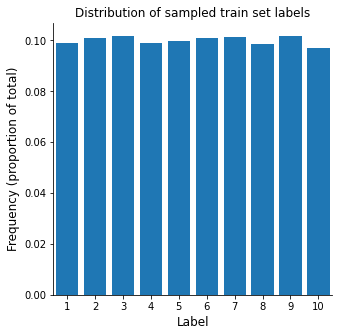

In [ ]:
# visualise the label distribution
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

x = list(label_counter.keys())
y = list(label_counter.values())

# convert y to proportion for easier comparison
y = [i / sum(y) for i in y]

plt.xlim(0.5,10.5)
plt.xticks(np.arange(1,11))

ax.bar(x,y)

plt.xlabel('Label', fontsize = 'large')
plt.ylabel('Frequency (proportion of total)', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Distribution of sampled train set labels')

# save model
save_path = '/content/drive/My Drive/ARP/figures/sample_label_distribution.png'

fig.savefig(save_path)

In [ ]:
list(y)

[0.10177551020408163,
 0.09855102040816327,
 0.10163265306122449,
 0.10095918367346939,
 0.09918367346938775,
 0.09959183673469388,
 0.09914285714285714,
 0.10144897959183674,
 0.09687755102040817,
 0.10083673469387755]

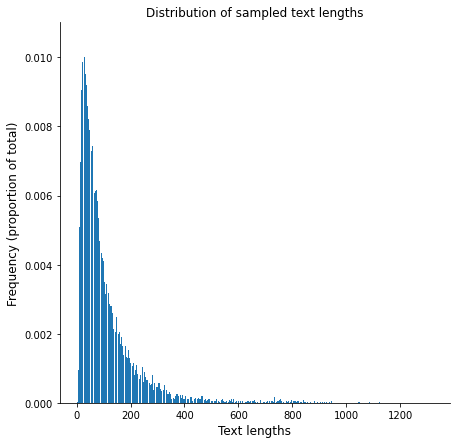

In [ ]:
# visualise the text length distribution
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)

x = token_counter.keys()
y = token_counter.values()

# convert y to proportion for easier comparison
y = [i / sum(y) for i in y]

ax.bar(x,y)

plt.xlabel('Text lengths', fontsize = 'large')
plt.ylabel('Frequency (proportion of total)', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Distribution of sampled text lengths')

# save model
save_path = '/content/drive/My Drive/ARP/figures/sample_text_distribution.png'

fig.savefig(save_path)

In [ ]:
# descriptive stats

# get list with each element repeated by its frequency
token_ele = sorted(token_counter.elements())

print(f'Count: {len(token_ele)}')
print(f'Mean: {np.mean(token_ele)}')
print(f'Median: {np.median(token_ele)}')
print(f'Standard deviation: {np.std(token_ele)}')
print(f'Min: {np.min(token_ele)}')
print(f'Max: {np.max(token_ele)}')


Count: 49000
Mean: 107.95436734693878
Median: 71.0
Standard deviation: 115.63624563871001
Min: 3
Max: 1319


### EDA of original train set

In [ ]:
## see whether these distributions are reflective of the original train data

# get distribution of labels and text lengths in the original train set

ori_label_counter = Counter()

for label, text in train_original:
  ori_label_counter[label] += 1 
  

print(ori_label_counter)

# make sure the number of labels = number of instances 
print(f'Number of labels: {sum(ori_label_counter.values())}')


Counter({5: 140000, 6: 140000, 3: 140000, 7: 140000, 2: 140000, 8: 140000, 4: 140000, 9: 140000, 10: 140000, 1: 140000})
Number of labels: 1400000


In [ ]:
ori_token_counter = Counter()
for label, text in train_original:
  ori_token_counter[len(tokenizer(text))] += 1

print(ori_token_counter)
print(f'Number of text lengths: {sum(ori_token_counter.values())}')

Optional: export/load tokens

In [ ]:
# token_counter is large and takes quite some time to execute, save these tokens
# to not have to run them every time

token_path = '/content/drive/My Drive/ARP/figures/original_token_lengths.pickle'

with open(token_path, 'wb') as f:
  pickle.dump(ori_token_counter, f)

In [ ]:
## load tokens from path


token_path = '/content/drive/My Drive/ARP/figures/original_token_lengths.pickle'

with open(token_path, 'rb') as f:
  ori_token_counter = pickle.load(f)

Visualise distributions

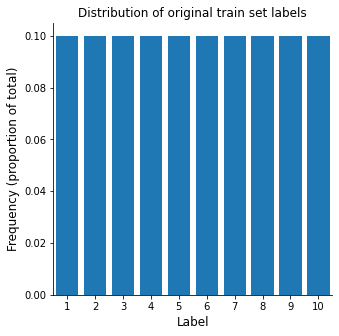

In [ ]:
# visualise the label distribution
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

x = list(ori_label_counter.keys())
y = list(ori_label_counter.values())

# convert y to proportion for easier comparison
y = [i / sum(y) for i in y]


plt.xlim(0.5,10.5)
plt.xticks(np.arange(1,11))

ax.bar(x,y)

plt.xlabel('Label', fontsize = 'large')
plt.ylabel('Frequency (proportion of total)', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Distribution of original train set labels')

# save model
save_path = '/content/drive/My Drive/ARP/figures/original_label_distribution.png'

fig.savefig(save_path)

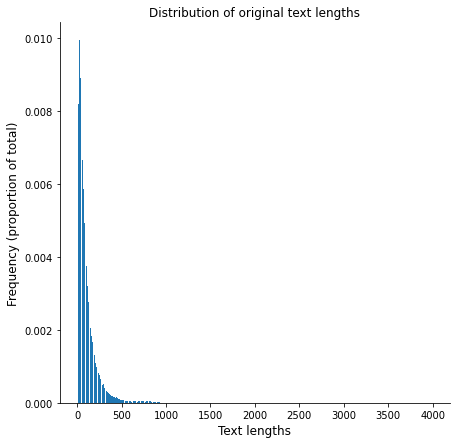

In [ ]:
# visualise the text length distribution
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)

x = ori_token_counter.keys()
y = ori_token_counter.values()

# convert y to proportion for easier comparison
y = [i / sum(y) for i in y]

ax.bar(x,y)

plt.xlabel('Text lengths', fontsize = 'large')
plt.ylabel('Frequency (proportion of total)', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Distribution of original text lengths')

# save model
save_path = '/content/drive/My Drive/ARP/figures/original_text_distribution.png'

fig.savefig(save_path)

In [ ]:
# descriptive stats

# descriptive stats

# get list with each element repeated by its frequency
ori_token_ele = sorted(ori_token_counter.elements())

print(f'Count: {len(ori_token_ele)}')
print(f'Mean: {np.mean(ori_token_ele)}')
print(f'Median: {np.median(ori_token_ele)}')
print(f'Standard deviation: {np.std(ori_token_ele)}')
print(f'Min: {np.min(ori_token_ele)}')
print(f'Max: {np.max(ori_token_ele)}')


Count: 1400000
Mean: 108.57893785714286
Median: 72.0
Standard deviation: 115.75599700089778
Min: 3
Max: 3998


How do lengths change over different labels in the sample? 

In [ ]:
# convert train sample to data frame to perform group by operations

train_df = pd.DataFrame(train_data)
train_df.columns = ['labels', 'text']
train_df

,labels,text
0,9,im gay and i like this girl but shes taken and...
1,8,Who was the best in American Idol tonight? I l...
2,3,"How can I cure excessive underarm sweat, I hav..."
3,2,why we substuite assay by titrations caliculat...
4,4,"what if you know your teacher likes you, but s..."
...,...,...
48995,6,What Submisssion hold would you use as a finis...
48996,10,what does the patriot act do to take away amer...
48997,8,is gospel or rap music better and why?is it be...
48998,7,is 630 a good score on the credit report? Not...


In [ ]:
# get length of text for each entry

text_len = [len(tokenizer(text)) for label, text in train_data]

In [ ]:
#add to dataframe
train_df.loc[:,'text_len'] = text_len

In [ ]:
train_df

,labels,text,text_len
0,9,im gay and i like this girl but shes taken and...,204
1,8,Who was the best in American Idol tonight? I l...,25
2,3,"How can I cure excessive underarm sweat, I hav...",113
3,2,why we substuite assay by titrations caliculat...,63
4,4,"what if you know your teacher likes you, but s...",217
...,...,...,...
48995,6,What Submisssion hold would you use as a finis...,63
48996,10,what does the patriot act do to take away amer...,86
48997,8,is gospel or rap music better and why?is it be...,100
48998,7,is 630 a good score on the credit report? Not...,104


In [ ]:
# get mean text lengths by class
mean_length = train_df.groupby('labels').agg(np.mean)
mean_length

,text_len
labels,
1,131.273775
2,116.103295
3,125.509438
4,100.322428
5,96.878893
6,84.747824
7,97.252062
8,80.495962
9,121.316022


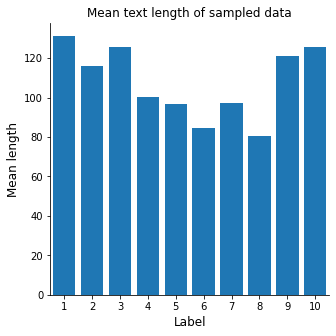

In [ ]:
# plot results

# visualise the label distribution
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

x = mean_length.index
y = mean_length['text_len']

plt.xlim(0.5,10.5)
plt.xticks(np.arange(1,11))

ax.bar(x,y)

plt.xlabel('Label', fontsize = 'large')
plt.ylabel('Mean length', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Mean text length of sampled data')

# save model
save_path = '/content/drive/My Drive/ARP/figures/text_lengths.png'

fig.savefig(save_path)

### Is this reflective of the original data?

In [ ]:
train_df_ori = pd.DataFrame(train_original)
train_df_ori.columns = ['labels', 'text']
train_df_ori

,labels,text
0,5,why doesn't an optical mouse work on a glass t...
1,6,What is the best off-road motorcycle trail ? l...
2,3,What is Trans Fat? How to reduce that? I heard...
3,7,How many planes Fedex has? I heard that it is ...
4,7,"In the san francisco bay area, does it make se..."
...,...,...
1399995,3,do all these ads on tv of yoko etc regarding h...
1399996,7,Ways to sell your video games? Like if you wan...
1399997,3,is it normal to have nots in your breast or bo...
1399998,1,Who can speak Hindi?? If you can write it here...


In [ ]:
# get length of text for each entry

text_len_ori = [len(tokenizer(text)) for label, text in train_original]

#add to dataframe
train_df_ori.loc[:,'text_len'] = text_len_ori

In [ ]:
train_df_ori

,labels,text,text_len
0,5,why doesn't an optical mouse work on a glass t...,169
1,6,What is the best off-road motorcycle trail ? l...,29
2,3,What is Trans Fat? How to reduce that? I heard...,139
3,7,How many planes Fedex has? I heard that it is ...,120
4,7,"In the san francisco bay area, does it make se...",196
...,...,...,...
1399995,3,do all these ads on tv of yoko etc regarding h...,38
1399996,7,Ways to sell your video games? Like if you wan...,30
1399997,3,is it normal to have nots in your breast or bo...,39
1399998,1,Who can speak Hindi?? If you can write it here...,20


In [ ]:
# long time required to process the len of text in this dataset - save dataframe for future use

path = '/content/drive/My Drive/ARP/data/original_test_length.csv'

train_df_ori.to_csv(path)

In [ ]:
# get mean text lengths by class
mean_length_ori = train_df_ori.groupby('labels').agg(np.mean)
mean_length_ori

,text_len
labels,
1,129.966164
2,116.927257
3,127.490821
4,100.320964
5,97.218207
6,84.055714
7,98.660564
8,82.054479
9,122.560407


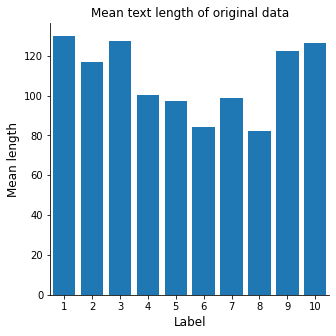

In [ ]:
# plot results

# visualise the label distribution
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

x = mean_length_ori.index
y = mean_length_ori['text_len']

plt.xlim(0.5,10.5)
plt.xticks(np.arange(1,11))

ax.bar(x,y)

plt.xlabel('Label', fontsize = 'large')
plt.ylabel('Mean length', fontsize = 'large')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.title('Mean text length of original data')

# save model
save_path = '/content/drive/My Drive/ARP/figures/text_lengths_ori.png'

fig.savefig(save_path)